In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipaddress
import re
import urllib.request
from bs4 import BeautifulSoup
import socket
import requests
from googlesearch import search
import whois
from datetime import date, datetime
import time
from dateutil.parser import parse as date_parse


def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def generate_data_set(url):

    data_set = []

    if not re.match(r"^https?", url):
        url = "http://" + url

    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    except:
        response = ""
        soup = -999

    domain = re.findall(r"://([^/]+)/?", url)[0]
    if re.match(r"^www.", domain):
        domain = domain.replace("www.", "")
    whois_response = whois.whois(domain)

    rank_checker_response = requests.post("https://www.checkpagerank.net/index.php", {
        "name": domain
    })

    try:
        global_rank = int(re.findall(
            r"Global Rank: ([0-9]+)", rank_checker_response.text)[0])
    except:
        global_rank = -1

     
    # 1.UsingIP
    try:
        ipaddress.ip_address(url)
        data_set.append(-1)
    except:
        data_set.append(1)

     
    # 2.LongURL
    if len(url) < 54:
        data_set.append(1)
    elif len(url) >= 54 and len(url) <= 75:
        data_set.append(0)
    else:
        data_set.append(-1)

     
    # 3.ShortURL
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|tr\.im|link\.zip\.net', url)
    if match:
        data_set.append(-1)
    else:
        data_set.append(1)

    # 4.Symbol@
    if re.findall("@", url):
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 5.Redirecting//
    list = [x.start(0) for x in re.finditer('//', url)]
    if list[len(list)-1] > 6:
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 6.PrefixSuffix-
    if re.findall(r"https?://[^\-]+-[^\-]+/", url):
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 7.SubDomains
    if len(re.findall("\.", url)) == 1:
        data_set.append(1)
    elif len(re.findall("\.", url)) == 2:
        data_set.append(0)
    else:
        data_set.append(-1)

     
    # 8.HTTPS
    try:
        if response.text:
            data_set.append(1)
    except:
        data_set.append(-1)

     
    # 9.DomainRegLen
    expiration_date = whois_response.expiration_date
    registration_length = 0
    try:
        expiration_date = min(expiration_date)
        today = time.strftime('%Y-%m-%d')
        today = datetime.strptime(today, '%Y-%m-%d')
        registration_length = abs((expiration_date - today).days)

        if registration_length / 365 <= 1:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(-1)

     
    # 10.Favicon
    if soup == -999:
        data_set.append(-1)
    else:
        try:
            for head in soup.find_all('head'):
                for head.link in soup.find_all('link', href=True):
                    dots = [x.start(0)
                            for x in re.finditer('\.', head.link['href'])]
                    if url in head.link['href'] or len(dots) == 1 or domain in head.link['href']:
                        data_set.append(1)
                        raise StopIteration
                    else:
                        data_set.append(-1)
                        raise StopIteration
        except StopIteration:
            pass

     
    # 11. NonStdPort
    try:
        port = domain.split(":")[1]
        if port:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)

     
    # 12. HTTPSDomainURL
    if re.findall(r"^https://", url):
        data_set.append(1)
    else:
        data_set.append(-1)

     
    # 13. RequestURL
    i = 0
    success = 0
    if soup == -999:
        data_set.append(-1)
    else:
        for img in soup.find_all('img', src=True):
            dots = [x.start(0) for x in re.finditer('\.', img['src'])]
            if url in img['src'] or domain in img['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for audio in soup.find_all('audio', src=True):
            dots = [x.start(0) for x in re.finditer('\.', audio['src'])]
            if url in audio['src'] or domain in audio['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for embed in soup.find_all('embed', src=True):
            dots = [x.start(0) for x in re.finditer('\.', embed['src'])]
            if url in embed['src'] or domain in embed['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for iframe in soup.find_all('iframe', src=True):
            dots = [x.start(0) for x in re.finditer('\.', iframe['src'])]
            if url in iframe['src'] or domain in iframe['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        try:
            percentage = success/float(i) * 100
            if percentage < 22.0:
                data_set.append(1)
            elif((percentage >= 22.0) and (percentage < 61.0)):
                data_set.append(0)
            else:
                data_set.append(-1)
        except:
            data_set.append(1)

     
    # 14. AnchorURL
    percentage = 0
    i = 0
    unsafe = 0
    ex = True
    if soup == -999:
        data_set.append(-1)
    else:
        for a in soup.find_all('a', href=True):
            # 2nd condition was 'JavaScript ::void(0)' but we put JavaScript because the space between javascript and :: might not be there in the actual a['href']
            if "#" in a['href'] or "javascript" in a['href'].lower() or "mailto" in a['href'].lower() or not (url in a['href'] or domain in a['href']):
                unsafe = unsafe + 1
            i = i + 1

        try:
            percentage = unsafe / float(i) * 100
        except:
            ex = False
            data_set.append(1)

        if(ex):
            if percentage < 31.0:
                data_set.append(1)
            elif ((percentage >= 31.0) and (percentage < 67.0)):
                data_set.append(0)
            else:
                data_set.append(-1)

     
    # 15. LinksInScriptTags<meta><script><link>
    i = 0
    success = 0
    if soup == -999:
        data_set.append(-1)
        data_set.append(0)
    else:
        for link in soup.find_all('link', href=True):
            dots = [x.start(0) for x in re.finditer('\.', link['href'])]
            if url in link['href'] or domain in link['href'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for script in soup.find_all('script', src=True):
            dots = [x.start(0) for x in re.finditer('\.', script['src'])]
            if url in script['src'] or domain in script['src'] or len(dots) == 1:
                success = success + 1
            i = i+1
        try:
            percentage = success / float(i) * 100
        except:
            data_set.append(1)

        if percentage < 17.0:
            data_set.append(1)
        elif((percentage >= 17.0) and (percentage < 81.0)):
            data_set.append(0)
        else:
            data_set.append(-1)
            
         
        # 16. ServerFormHandler
        if len(soup.find_all('form', action=True))==0:
            data_set.append(1)
        else :
            for form in soup.find_all('form', action=True):
                if form['action'] == "" or form['action'] == "about:blank":
                    data_set.append(-1)
                    break
                elif url not in form['action'] and domain not in form['action']:
                    data_set.append(0)
                    break
                else:
                    data_set.append(1)
                    break

     
    # 17. InfoEmail
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"[mail\(\)|mailto:?]", response.text):
            data_set.append(-1)
        else:
            data_set.append(1)

     
    # 18. AbnormalURL
    if response == "":
        data_set.append(-1)
    else:
        if response.text == whois_response:
            data_set.append(1)
        else:
            data_set.append(-1)
       
    # 19. WebsiteForwarding
    if response == "":
        data_set.append(-1)
    else:
        if len(response.history) <= 1:
            data_set.append(-1)
        elif len(response.history) <= 4:
            data_set.append(0)
        else:
            data_set.append(1)

     
    # 20. StatusBarCust
    if response == "":
        data_set.append(-1)
    else:
        if re.findall("<script>.+onmouseover.+</script>", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

     
    # 21. DisableRightClick
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"event.button ?== ?2", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

    # 22. UsingPopupWindow
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"alert\(", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

     
    # 23. IframeRedirection
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

    # 24. AgeofDomain
    if response == "":
        data_set.append(-1)
    else:
        try:
            registration_date = re.findall(
                    r'Registration Date:</div><div class="df-value">([^<]+)</div>', whois_response.text)[0]
            if diff_month(date.today(), date_parse(registration_date)) >= 6:
                data_set.append(-1)
            else:
                data_set.append(1)
        except:
            data_set.append(1)

     
    # 25. DNSRecord
    dns = 1
    try:
        d = whois.whois(domain)
    except:
        dns = -1
    if dns == -1:
        data_set.append(-1)
    else:
        if registration_length / 365 <= 1:
            data_set.append(-1)
        else:
            data_set.append(1)

    # 26. WebsiteTraffic
    try:
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find("REACH")['RANK']
        rank = int(rank)
        if (rank < 100000):
            data_set.append(1)
        else:
            data_set.append(0)
    except :
        data_set.append(-1)

     
    # 27. PageRank
    try:
        if global_rank > 0 and global_rank < 100000:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)

     
    # 28. GoogleIndex
    site = search(url, 5)
    if site:
        data_set.append(1)
    else:
        data_set.append(-1)

    # 29. LinksPointingToPage
    if response == "":
        data_set.append(-1)
    else:
        number_of_links = len(re.findall(r"<a href=", response.text))
        if number_of_links == 0:
            data_set.append(1)
        elif number_of_links <= 2:
            data_set.append(0)
        else:
            data_set.append(-1)

     
    # 30. StatsReport
    url_match = re.search(
        'at\.ua|usa\.cc|baltazarpresentes\.com\.br|pe\.hu|esy\.es|hol\.es|sweddy\.com|myjino\.ru|96\.lt|ow\.ly', url)
    try:
        ip_address = socket.gethostbyname(domain)
        ip_match = re.search('146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
                             '107\.151\.148\.44|107\.151\.148\.107|64\.70\.19\.203|199\.184\.144\.27|107\.151\.148\.108|107\.151\.148\.109|119\.28\.52\.61|54\.83\.43\.69|52\.69\.166\.231|216\.58\.192\.225|'
                             '118\.184\.25\.86|67\.208\.74\.71|23\.253\.126\.58|104\.239\.157\.210|175\.126\.123\.219|141\.8\.224\.221|10\.10\.10\.10|43\.229\.108\.32|103\.232\.215\.140|69\.172\.201\.153|'
                             '216\.218\.185\.162|54\.225\.104\.146|103\.243\.24\.98|199\.59\.243\.120|31\.170\.160\.61|213\.19\.128\.77|62\.113\.226\.131|208\.100\.26\.234|195\.16\.127\.102|195\.16\.127\.157|'
                             '34\.196\.13\.28|103\.224\.212\.222|172\.217\.4\.225|54\.72\.9\.51|192\.64\.147\.141|198\.200\.56\.183|23\.253\.164\.103|52\.48\.191\.26|52\.214\.197\.72|87\.98\.255\.18|209\.99\.17\.27|'
                             '216\.38\.62\.18|104\.130\.124\.96|47\.89\.58\.141|78\.46\.211\.158|54\.86\.225\.156|54\.82\.156\.19|37\.157\.192\.102|204\.11\.56\.48|110\.34\.231\.42', ip_address)
        if url_match:
            data_set.append(-1)
        elif ip_match:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)
        

    return data_set



In [3]:
data = pd.read_csv("phishing.csv")
data.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [4]:
data.shape

(11054, 32)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11054 entries, 0 to 11053
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Index                11054 non-null  int64
 1   UsingIP              11054 non-null  int64
 2   LongURL              11054 non-null  int64
 3   ShortURL             11054 non-null  int64
 4   Symbol@              11054 non-null  int64
 5   Redirecting//        11054 non-null  int64
 6   PrefixSuffix-        11054 non-null  int64
 7   SubDomains           11054 non-null  int64
 8   HTTPS                11054 non-null  int64
 9   DomainRegLen         11054 non-null  int64
 10  Favicon              11054 non-null  int64
 11  NonStdPort           11054 non-null  int64
 12  HTTPSDomainURL       11054 non-null  int64
 13  RequestURL           11054 non-null  int64
 14  AnchorURL            11054 non-null  int64
 15  LinksInScriptTags    11054 non-null  int64
 16  ServerFormHandler    1

In [6]:
data.nunique()

Index                  11054
UsingIP                    2
LongURL                    3
ShortURL                   2
Symbol@                    2
Redirecting//              2
PrefixSuffix-              2
SubDomains                 3
HTTPS                      3
DomainRegLen               2
Favicon                    2
NonStdPort                 2
HTTPSDomainURL             2
RequestURL                 2
AnchorURL                  3
LinksInScriptTags          3
ServerFormHandler          3
InfoEmail                  2
AbnormalURL                2
WebsiteForwarding          2
StatusBarCust              2
DisableRightClick          2
UsingPopupWindow           2
IframeRedirection          2
AgeofDomain                2
DNSRecording               2
WebsiteTraffic             3
PageRank                   2
GoogleIndex                2
LinksPointingToPage        3
StatsReport                2
class                      2
dtype: int64

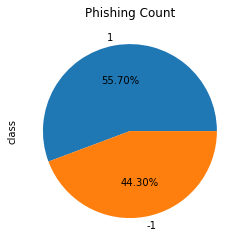

In [7]:
data['class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

In [8]:
df = data.drop(['Index'],axis = 1)

In [9]:
df.head()

,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,Favicon,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,-1,0,-1,1,-1,-1,1,1,-1,1,...,1,1,1,1,1,-1,1,-1,-1,1


In [10]:
# Splitting the dataset into dependant and independant fetature

X = df.drop(["class"],axis =1)
y = df["class"]

In [11]:
# Splitting the dataset into train and test sets: 80-20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8843, 30), (8843,), (2211, 30), (2211,))

In [12]:
# Creating holders to store the model performance results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))

In [13]:
# Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)

# fit the model 
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [14]:
y_train_gbc = gbc.predict(X_train)
y_test_gbc = gbc.predict(X_test)

In [15]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_gbc = metrics.accuracy_score(y_train,y_train_gbc)
acc_test_gbc = metrics.accuracy_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Accuracy on training Data: {:.3f}".format(acc_train_gbc))
print("Gradient Boosting Classifier : Accuracy on test Data: {:.3f}".format(acc_test_gbc))
print()

f1_score_train_gbc = metrics.f1_score(y_train,y_train_gbc)
f1_score_test_gbc = metrics.f1_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_gbc))
print("Gradient Boosting Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_gbc))
print()

recall_score_train_gbc = metrics.recall_score(y_train,y_train_gbc)
recall_score_test_gbc =  metrics.recall_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Recall on training Data: {:.3f}".format(recall_score_train_gbc))
print("Gradient Boosting Classifier : Recall on test Data: {:.3f}".format(recall_score_test_gbc))
print()

precision_score_train_gbc = metrics.precision_score(y_train,y_train_gbc)
precision_score_test_gbc = metrics.precision_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : precision on training Data: {:.3f}".format(precision_score_train_gbc))
print("Gradient Boosting Classifier : precision on test Data: {:.3f}".format(precision_score_test_gbc))

Gradient Boosting Classifier : Accuracy on training Data: 0.989
Gradient Boosting Classifier : Accuracy on test Data: 0.974

Gradient Boosting Classifier : f1_score on training Data: 0.990
Gradient Boosting Classifier : f1_score on test Data: 0.977

Gradient Boosting Classifier : Recall on training Data: 0.994
Gradient Boosting Classifier : Recall on test Data: 0.989

Gradient Boosting Classifier : precision on training Data: 0.986
Gradient Boosting Classifier : precision on test Data: 0.966


In [16]:
print(metrics.classification_report(y_test, y_test_gbc))

              precision    recall  f1-score   support

          -1       0.99      0.96      0.97       976
           1       0.97      0.99      0.98      1235

    accuracy                           0.97      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



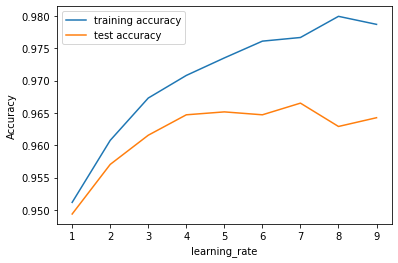

In [17]:
training_accuracy = []
test_accuracy = []
# try learning_rate from 0.1 to 0.9
depth = range(1,10)
for n in depth:
    forest_test =  GradientBoostingClassifier(learning_rate = n*0.1)

    forest_test.fit(X_train, y_train)
    training_accuracy.append(forest_test.score(X_train, y_train))
    test_accuracy.append(forest_test.score(X_test, y_test))
    
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("learning_rate")
plt.legend();

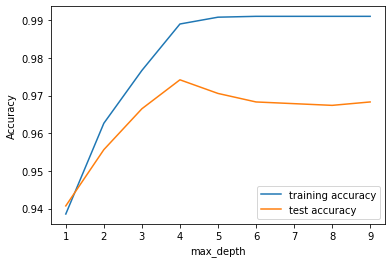

In [18]:
training_accuracy = []
test_accuracy = []
depth = range(1,10,1)
for n in depth:
    forest_test =  GradientBoostingClassifier(max_depth=n,learning_rate = 0.7)

    forest_test.fit(X_train, y_train)
    training_accuracy.append(forest_test.score(X_train, y_train))
    test_accuracy.append(forest_test.score(X_test, y_test))
    

plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend();

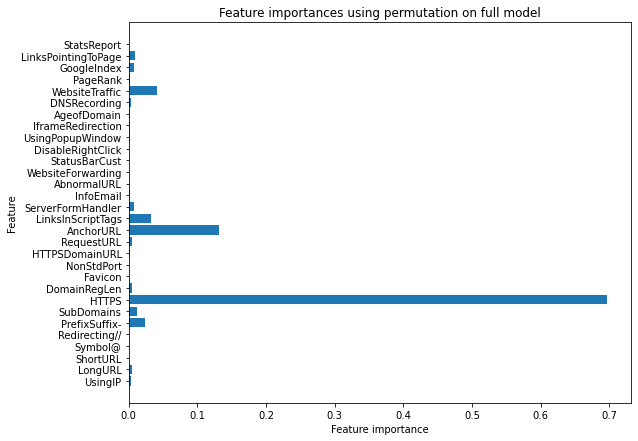

In [23]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), gbc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.title("Feature importances using permutation on full model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [33]:
generate_data_set("http://gc-ap.co.za")

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1]

In [34]:
y=gbc.predict([generate_data_set("http://gc-ap.co.za")])


In [35]:
if y==1:
    print("Legitimate")
else:
    print("Phishing")

Phishing
